# Etude du Dataset SILICONE


In [1]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline, Trainer, TrainingArguments
from tqdm import tqdm
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
from tasknet import Adapter
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score

from CustomTrainer import CustomTrainer

# Chargement du Dataset SILICONE

In [2]:
# Load SILICONE dataset in its Dyda_da config (only 4 possible dialog acts)

silicone_dyda = load_dataset('silicone', 'dyda_da')
dyda_train = silicone_dyda['train']
dyda_valid = silicone_dyda['validation']
dyda_test = silicone_dyda['test']

Found cached dataset silicone (C:/Users/robin/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dyda_train

Dataset({
    features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
    num_rows: 87170
})

In [4]:
num_labels = 4
labels = ['commissive', 'directive', 'inform', 'question']
id2label = {0: 'commissive',
            1: 'directive', 
            2: 'inform', 
            3: 'question'
}
label2id = {value: key for key, value in id2label.items()}

In [5]:
dyda_train_df = pd.DataFrame.from_dict(dyda_train[:])
dyda_test_df = pd.DataFrame.from_dict(dyda_test[:])
dyda_test_df.head()

,Utterance,Dialogue_Act,Dialogue_ID,Label,Idx
0,"hey man , you wanna buy some weed ?",directive,1,1,0
1,some what ?,question,1,3,1
2,"weed ! you know ? pot , ganja , mary jane some...",directive,1,1,2
3,"oh , umm , no thanks .",commissive,1,0,3
4,i also have blow if you prefer to do a few lin...,directive,1,1,4


# Chargement du modèle préentraîné

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'microsoft/deberta-v3-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, 
    ignore_mismatched_sizes=True,
    num_labels=num_labels, 
    #id2label=id2label, label2id=label2id
).to(device)

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\robin\AppData\Roaming\Python\Python310\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.wei

# First Preprocessing

In [7]:
def tokenize_function(example):
    return tokenizer(example["Utterance"], truncation=True, max_length=128)

valid_tkz = dyda_valid.map(tokenize_function, batched=True)
train_tkz = dyda_train.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/88 [00:00<?, ?ba/s]

In [8]:
train_tkz

Dataset({
    features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 87170
})

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

samples = train_tkz[:8]
samples = {k: v for k, v in samples.items() if k not in ["Utterance", "Dialogue_Act", "Idx", "Dialogue_ID"]}
[len(x) for x in samples["input_ids"]]

[16, 16, 14, 27, 24, 23, 32, 31]

In [10]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Label': torch.Size([8]),
 'input_ids': torch.Size([8, 32]),
 'token_type_ids': torch.Size([8, 32]),
 'attention_mask': torch.Size([8, 32])}

In [11]:
train_sample = train_tkz[:200]
train_sample = {k: v for k, v in train_sample.items() if k not in ["Utterance", "Dialogue_Act", "Idx", "Dialogue_ID"]}

valid_sample = valid_tkz[:100]
valid_sample = {k: v for k, v in valid_sample.items() if k not in ["Utterance", "Dialogue_Act", "Idx", "Dialogue_ID"]}

# Preprocessing V2

In [7]:
# build smaller dataset

dyda_train_sample = dyda_train[:2000]
dyda_valid_sample = dyda_valid[:50]
dyda_test_sample = dyda_test[:100]

In [8]:
train_inputs = tokenizer(dyda_train_sample['Utterance'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
valid_inputs = tokenizer(dyda_valid_sample['Utterance'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
test_inputs = tokenizer(dyda_test_sample['Utterance'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')

#train_labels = tokenizer(dyda_train['Dialogue_Act'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
#valid_labels = tokenizer(dyda_valid['Dialogue_Act'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')

In [9]:
train_inputs

{'input_ids': tensor([[   1,  504,  366,  ...,    0,    0,    0],
        [   1,  274,  391,  ...,    0,    0,    0],
        [   1,  339,  333,  ...,    0,    0,    0],
        ...,
        [   1, 2163, 1570,  ...,    0,    0,    0],
        [   1,  339,  333,  ...,    0,    0,    0],
        [   1,  584,  507,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [10]:
# Create a TensorDataset from the input data and labels
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_inputs['token_type_ids'], torch.tensor(dyda_train_sample['Label']))
valid_dataset = TensorDataset(valid_inputs['input_ids'], valid_inputs['attention_mask'], valid_inputs['token_type_ids'], torch.tensor(dyda_valid_sample['Label']))
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_inputs['token_type_ids'], torch.tensor(dyda_test_sample['Label']))

# Create DataLoader objects for the training and validation sets
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=16)

# Training

In [12]:
# define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=50,
    save_total_limit=2,
    save_steps=50
)

# define the trainer object
trainer = CustomTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=train_dataset,            # training dataset
    eval_dataset=valid_dataset,               # evaluation dataset
    #compute_metrics=lambda pred, labels: {"accuracy": accuracy_score(labels, pred.argmax(axis=1))},
    #data_collator=data_collator,
    #tokenizer=tokenizer,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'token_type_ids': torch.stack([item[2] for item in data]),
                                'labels': torch.tensor([item[3] for item in data])},
)

# start the training process
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
  Number of trainable parameters = 184425220


Labels found
tensor(1.3466, grad_fn=<NllLossBackward0>)


Step,Training Loss,Validation Loss
50,1.185900,1.173781
100,0.630600,0.670453
150,0.272500,0.636376
200,0.323500,0.526452
250,0.388300,0.485674
300,0.335800,0.811329
350,0.309800,0.651624
400,0.153500,0.626353
450,0.203400,0.633578
500,0.218600,0.585865


Labels found
tensor(1.3306, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3179, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3465, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3216, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3174, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3150, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3399, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3270, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3328, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3116, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3269, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3141, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3198, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3027, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3010, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3279, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3063, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.3257, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.1738)


Saving model checkpoint to ./results\checkpoint-50
Configuration saved in ./results\checkpoint-50\config.json
Model weights saved in ./results\checkpoint-50\pytorch_model.bin


Labels found
tensor(1.1445, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.1070, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.1675, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.1495, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0787, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0497, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.1501, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0376, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0571, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0169, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0436, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0953, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.9486, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.9503, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.0365, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.1279, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.9905, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.9804, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.6705)


Saving model checkpoint to ./results\checkpoint-100
Configuration saved in ./results\checkpoint-100\config.json
Model weights saved in ./results\checkpoint-100\pytorch_model.bin


Labels found
tensor(0.2888, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4822, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4090, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3756, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3000, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2318, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2927, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.7523, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5648, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2564, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3292, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.6934, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2152, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3462, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4964, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1128, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3042, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3876, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.6364)


Saving model checkpoint to ./results\checkpoint-150
Configuration saved in ./results\checkpoint-150\config.json
Model weights saved in ./results\checkpoint-150\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-50] due to args.save_total_limit


Labels found
tensor(0.5784, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.7163, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3205, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2741, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.7857, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3166, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1868, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3412, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1692, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2596, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1991, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1398, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4618, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.5990, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.6383, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3414, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2628, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1419, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.5265)


Saving model checkpoint to ./results\checkpoint-200
Configuration saved in ./results\checkpoint-200\config.json
Model weights saved in ./results\checkpoint-200\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-100] due to args.save_total_limit


Labels found
tensor(0.5778, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2038, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1719, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4965, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3255, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3099, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4278, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5607, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5177, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4831, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1928, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.8326, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1983, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0882, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2957, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2530, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.8336, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2001, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.4857)


Saving model checkpoint to ./results\checkpoint-250
Configuration saved in ./results\checkpoint-250\config.json
Model weights saved in ./results\checkpoint-250\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-150] due to args.save_total_limit


Labels found
tensor(0.2005, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2265, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4229, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1604, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1870, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0983, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1606, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0564, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0976, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3490, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.6384, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4425, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1985, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3582, grad_fn=<NllLossBackward0>)
Labels found
tensor(1.1376, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.6386, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2091, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0636, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.8113)


Saving model checkpoint to ./results\checkpoint-300
Configuration saved in ./results\checkpoint-300\config.json
Model weights saved in ./results\checkpoint-300\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-200] due to args.save_total_limit


Labels found
tensor(0.2899, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2639, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1497, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2613, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1742, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5104, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3006, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1464, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.6058, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2137, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2019, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4586, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5384, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5307, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1062, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5504, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0527, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1573, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.6516)


Saving model checkpoint to ./results\checkpoint-350
Configuration saved in ./results\checkpoint-350\config.json
Model weights saved in ./results\checkpoint-350\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-250] due to args.save_total_limit


Labels found
tensor(0.3826, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2955, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4247, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3551, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1972, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.6128, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2502, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2945, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2493, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1972, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4265, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3911, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5458, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1974, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4293, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3674, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2254, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1298, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.6264)


Saving model checkpoint to ./results\checkpoint-400
Configuration saved in ./results\checkpoint-400\config.json
Model weights saved in ./results\checkpoint-400\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-300] due to args.save_total_limit


Labels found
tensor(0.3344, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2102, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4826, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3312, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4270, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3666, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1907, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1436, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1189, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2902, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3772, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.6120, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1580, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3047, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2756, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3792, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1307, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1935, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.6336)


Saving model checkpoint to ./results\checkpoint-450
Configuration saved in ./results\checkpoint-450\config.json
Model weights saved in ./results\checkpoint-450\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-350] due to args.save_total_limit


Labels found
tensor(0.2755, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3632, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0404, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0549, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0695, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3604, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1075, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4722, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3344, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4971, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3046, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1167, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3011, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5045, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3762, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2788, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2429, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1508, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.5859)


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-400] due to args.save_total_limit


Labels found
tensor(0.2860, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2840, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2185, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0624, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1137, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3223, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1461, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2608, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1664, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2009, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2357, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2266, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3565, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1000, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2593, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2032, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0623, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2678, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.5694)


Saving model checkpoint to ./results\checkpoint-550
Configuration saved in ./results\checkpoint-550\config.json
Model weights saved in ./results\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-450] due to args.save_total_limit


Labels found
tensor(0.0415, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1935, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2671, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2589, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3036, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1381, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1375, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0788, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0285, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1720, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3219, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5063, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2411, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0375, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0797, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3846, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1255, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0685, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.6264)


Saving model checkpoint to ./results\checkpoint-600
Configuration saved in ./results\checkpoint-600\config.json
Model weights saved in ./results\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-500] due to args.save_total_limit


Labels found
tensor(0.4385, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4771, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5595, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1830, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3422, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1000, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0111, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1036, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0819, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1720, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0194, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0473, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0743, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0205, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3445, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2168, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3852, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3993, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.8275)


Saving model checkpoint to ./results\checkpoint-650
Configuration saved in ./results\checkpoint-650\config.json
Model weights saved in ./results\checkpoint-650\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-550] due to args.save_total_limit


Labels found
tensor(0.1381, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2764, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0645, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0493, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0487, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0872, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0084, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1430, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2530, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2708, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2651, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3149, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1117, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0099, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0711, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0107, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1359, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0725, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.8790)


Saving model checkpoint to ./results\checkpoint-700
Configuration saved in ./results\checkpoint-700\config.json
Model weights saved in ./results\checkpoint-700\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-600] due to args.save_total_limit


Labels found
tensor(0.1683, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0369, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5041, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1119, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0430, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2082, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0743, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3647, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1165, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0247, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1057, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3269, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1139, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1402, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0231, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0105, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0491, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5898, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.7620)


Saving model checkpoint to ./results\checkpoint-750
Configuration saved in ./results\checkpoint-750\config.json
Model weights saved in ./results\checkpoint-750\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-650] due to args.save_total_limit


Labels found
tensor(0.1138, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0196, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0404, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1062, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0294, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0267, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3526, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0643, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0526, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0133, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0059, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0810, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2431, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2443, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1601, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1101, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1216, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0616, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.8813)


Saving model checkpoint to ./results\checkpoint-800
Configuration saved in ./results\checkpoint-800\config.json
Model weights saved in ./results\checkpoint-800\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-700] due to args.save_total_limit


Labels found
tensor(0.0131, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0070, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0099, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0163, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0178, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0244, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0099, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0113, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.4613, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1761, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0110, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0054, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0432, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0099, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0263, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0740, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0510, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3045, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(0.8536)


Saving model checkpoint to ./results\checkpoint-850
Configuration saved in ./results\checkpoint-850\config.json
Model weights saved in ./results\checkpoint-850\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-750] due to args.save_total_limit


Labels found
tensor(0.0157, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0053, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0079, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1311, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0044, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1330, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1636, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0051, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0043, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0681, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0544, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2220, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0061, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0034, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0167, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2546, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0123, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0065, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.4243)


Saving model checkpoint to ./results\checkpoint-900
Configuration saved in ./results\checkpoint-900\config.json
Model weights saved in ./results\checkpoint-900\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-800] due to args.save_total_limit


Labels found
tensor(0.1167, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1159, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1227, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0172, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0468, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0031, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1490, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0106, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0922, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0676, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1085, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0738, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0092, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0181, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0067, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2793, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0086, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0090, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.3563)


Saving model checkpoint to ./results\checkpoint-950
Configuration saved in ./results\checkpoint-950\config.json
Model weights saved in ./results\checkpoint-950\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-850] due to args.save_total_limit


Labels found
tensor(0.0541, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0129, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0698, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0151, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0133, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0643, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0148, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0379, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0283, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0045, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0259, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1480, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0162, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0152, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.3143, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1445, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0069, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0071, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.5542)


Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json
Model weights saved in ./results\checkpoint-1000\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-900] due to args.save_total_limit


Labels found
tensor(0.0525, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0157, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1167, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0046, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.5168, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0053, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0047, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0078, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0039, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0077, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0094, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0052, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1722, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0464, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0069, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0321, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1331, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0056, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.2425)


Saving model checkpoint to ./results\checkpoint-1050
Configuration saved in ./results\checkpoint-1050\config.json
Model weights saved in ./results\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-950] due to args.save_total_limit


Labels found
tensor(0.3273, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0452, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0087, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0710, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0065, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0053, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0031, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0036, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0036, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0246, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0063, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0111, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0022, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0077, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0032, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0037, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0909, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0033, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.4078)


Saving model checkpoint to ./results\checkpoint-1100
Configuration saved in ./results\checkpoint-1100\config.json
Model weights saved in ./results\checkpoint-1100\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-1000] due to args.save_total_limit


Labels found
tensor(0.0039, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1182, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0052, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0102, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0035, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0794, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0035, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0049, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0084, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0016, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0027, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0020, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0169, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0022, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0019, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0018, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1383, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0016, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.4930)


Saving model checkpoint to ./results\checkpoint-1150
Configuration saved in ./results\checkpoint-1150\config.json
Model weights saved in ./results\checkpoint-1150\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-1050] due to args.save_total_limit


Labels found
tensor(0.0031, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0020, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0022, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0053, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0062, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0013, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0029, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0022, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0764, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0033, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.2516, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0018, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0022, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0030, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0023, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1006, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0033, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0039, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.4897)


Saving model checkpoint to ./results\checkpoint-1200
Configuration saved in ./results\checkpoint-1200\config.json
Model weights saved in ./results\checkpoint-1200\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-1100] due to args.save_total_limit


Labels found
tensor(0.0019, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.1170, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0068, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0907, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0026, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0017, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0033, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0038, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0021, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0023, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0028, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0248, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0532, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0019, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0012, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0045, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0085, grad_fn=<NllLossBackward0>)
Labels found
tensor(0.0111, grad_fn=<NllLossBack

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.4901)


Saving model checkpoint to ./results\checkpoint-1250
Configuration saved in ./results\checkpoint-1250\config.json
Model weights saved in ./results\checkpoint-1250\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-1150] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1250, training_loss=0.24978328368663788, metrics={'train_runtime': 14560.9559, 'train_samples_per_second': 1.374, 'train_steps_per_second': 0.086, 'total_flos': 1315602493440000.0, 'train_loss': 0.24978328368663788, 'epoch': 10.0})

# Prediction

In [13]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 100
  Batch size = 64


Labels found
tensor(0.5203)


Labels found
tensor(0.9748)
(100, 4) (100,)


In [14]:
accuracy = evaluate.load("accuracy")
accuracy.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.78}

# Evaluation

In [15]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 50
  Batch size = 64


Labels found
tensor(1.4901)


{'eval_loss': 1.4901407957077026,
 'eval_runtime': 10.2171,
 'eval_samples_per_second': 4.894,
 'eval_steps_per_second': 0.098,
 'epoch': 10.0}

In [2]:
# Prediction

#model_inputs_test = tokenizer(dyda_test_sample['Utterance'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
#model_inputs_test = test_inputs['input_ids'].tolist()
#preds = []
#for input in model_inputs_test:
#    pred = model(torch.tensor([input]))
#    preds.append(pred)
#preds = model(model_inputs_test)

In [3]:
#print(preds[:5])

# Results Analysis

In [7]:
steps = list(range(50, 1300, 50))
training_loss = [1.185900,
    0.630600,
    0.272500,
    0.323500,
    0.388300,
    0.335800,
    0.309800,
    0.153500,
    0.203400,
    0.218600,
    0.210800,
    0.157300,
    0.174500,
    0.158900,
    0.170900,
    0.195700,
    0.063600,
    0.086400,
    0.084600,
    0.084000,
    0.095200,
    0.057500,
    0.041100,
    0.034100,
    0.004700,
]

validation_loss = [
    1.173781,
    0.670453,
    0.636376,
    0.526452,
    0.485674,
    0.811329,
    0.651624,
    0.626353,
    0.633578,
    0.585865,
    0.569437,
    0.626436,
    0.827506,
    0.879034,
    0.762041,
    0.881274,
    0.853634,
    1.424341,
    1.356294,
    1.554175,
    1.242487,
    1.407756,
    1.493006,
    1.489740,
    1.490141,
]

C:\Users\robin\AppData\Local\Temp\ipykernel_31120\2466661233.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(steps, training_loss, 'b', label='Training Loss', color='red')
C:\Users\robin\AppData\Local\Temp\ipykernel_31120\2466661233.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(steps, validation_loss, 'b', label='Validation Loss', color='blue')


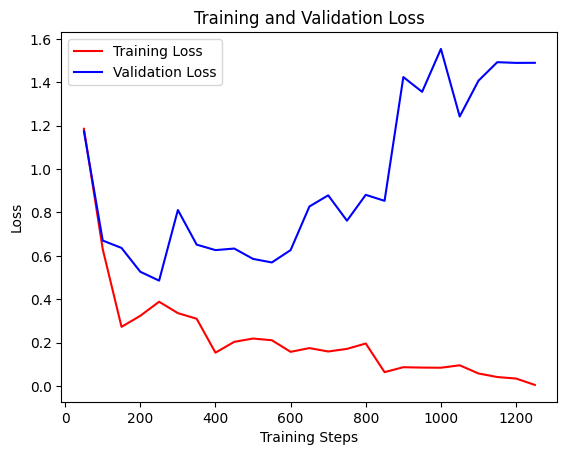

In [12]:
import matplotlib.pyplot as plt

plt.plot(steps, training_loss, 'b', label='Training Loss', color='red')
plt.plot(steps, validation_loss, 'b', label='Validation Loss', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/deberta_fine_tuning_2000_50.jpg')
plt.show()

In [ ]:
# Model explainability (confusion matrix) ?